# Part 1 : Supervised Learning

This notebook deals exclusively with Supervised Learning algorithms (Classification & Regression) applied to 
the freely available South Africa Heart Disease dataset (available [here](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data)). 


All modelling is perfomed with the powerful scikit-learn python package. An additional non-ordinary
package (mlxtend) is installed for a specific task (sequencial feature selection) 

In total there are 3 notebooks devoted to the exaustive study of this dataset:
    - Part 1: Supervised Learning
    - Part 2: Unsupervised Learning
    - Part 3: Association Mining
 
This work has been carried as part of the course:
    - Course      : Introduction to Machine Learning and Data Mining
    - University : DTU, Lyngby (Denmark)
    - Dates       : 5-9 March 2018
 
### Special Dependencies
    - mlxtend (pip install mlxtend)

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn import tree, model_selection
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import sklearn.linear_model as lm

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.linalg import svd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import graphviz
import logging
import sys

sys.path.append('/home/bejm/projects/ml_tools')
import ml_tools.ann_tools as net

### HELPER FUNCTIONS

In [2]:
def binarize(x):
    if x == 'Present':
        return 1
    else:
        return 0

def gen_logger(nm='my_logger',verb='INFO',log_pth=None):
    '''Simple logger function'''
    log = logging.getLogger(nm)
    log.handlers = []
    log.setLevel(verb)
    ch = logging.StreamHandler()        
    formatter = logging.Formatter('%(message)s')
    ch.setFormatter(formatter)
    ch.setLevel(logging.DEBUG)
    log.addHandler(ch)

    if log_pth is not None:
        fh = logging.FileHandler(log_pth,mode='w')
        formatter = logging.Formatter('%(message)s')
        fh.setFormatter(formatter)
        fh.setLevel(logging.DEBUG)
        log.addHandler(fh)
        log.propagate = False
    return log  

def compare_models(res_model1, res_model2, alpha=0.05):
    '''Comparing two models via confidence intervals.
    Confidence intervals are extracted from t-Student's cdf function.
    
    Args:
        res_model1 (pd.Series) : outer cv fold errors of model 1
        res_model2 (pd.Series) : outer cv fold errors of model 2
        alpha (float)          : 1 - alpha = confidence
        
    Returns:
        Confidence interval zL, zH in a list [zL, zH]
    '''
    K = len(res_model1)
    z = res_model1 - res_model2
    zb = z.mean()
    nu = K-1
    sig =  (z-zb).std()  / np.sqrt(K-1)
    
    zL = zb + sig * stats.t.ppf(alpha/2, nu);
    zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

    if zL <= 0 and zH >= 0 :
        print('The two models are not significantly different')        
    else:
        print('The two models are significantly different.')
    return [zL, zH]


def bin_digitize(X, bins=10):
    df = pd.DataFrame(X)
    for col in df.columns:
        nbins = np.linspace(df[col].min(), df[col].max(), bins)
        df[col] = np.digitize(df[col], nbins)
    return df.values


def mapping_list(array, key='bins'):
    out=[]
    for i in array:
        out.append({key : i})
    return out


def majority_class(y):
    '''A simple majority class classifier'''
    if y.sum() >= len(y) / 2.:
        y_est = 1
    else:
        y_est = 0
        
    return y_est

### CUSTOM TRANSFORMER CLASSES

In [69]:
class FilterExtractor(BaseEstimator, TransformerMixin):
    """Subset rows/columns using DataFrame.filter"""
    
    def __init__(self, regex=None, items=None, like=None, axis=1):
        self.regex = regex
        self.items = items
        self.like = like
        self.axis=axis
    
    def transform(self, X):
        subset = X.filter(regex=self.regex,items=self.items,like=self.like, axis=self.axis)
        return subset
    
    def fit(self, X, *_):
        return self


class ExtraFeaturesTransform(BaseEstimator, TransformerMixin):
    '''Creates extra features from X (Polynomial or interaction terms).'''
    
    def __init__(self, power_dict=None, int_list=None):
        self.power_dict = power_dict
        self.int_list = int_list
        
    def _newX(self, X):
        if self.power_dict is not None:
            for key in self.power_dict.keys():
                for val in self.power_dict[key]:
                    if val != 1:
                        new_col_name = 'p({}){}'.format(key, str(val))
                        X[new_col_name] = X[key]**val
                    else:
                        raise ValueError('the variable {} already exists. Cannot generate a new variable.'.format(key))

        if self.int_list is not None:
            for inlist in self.int_list:
                join_name = ','.join(inlist)
                new_col_name = 'int({})'.format(join_name)
                X[new_col_name] = X[inlist[0]] * X[inlist[1]]
                
        return X
    
    def transform(self, X):
        
        X_ = X.copy()
        return self._newX(X_)
           
    def fit(self, X, *_):
        X__ = X.copy()
        X__ = self._newX(X__)
        self.feature_cols_ = X__.columns
        
        return self

In [3]:
sns.set_context("notebook", font_scale=1.5)
pd.options.mode.chained_assignment = None

## Loading dataset

The dataset has been saved locally for convenience.

In [4]:
# Loading the data
data = pd.read_csv('data.csv')
data.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


### Inspecting the data types
Several features are floats and ints. The famhist feature is a string (object in python dtypes)

In [5]:
# data types
data.dtypes

row.names      int64
sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

### Number of rows with missing values
We are fortunate since this dataset is clean so there is no need to deal with missing value imputation/removal

In [6]:
len(data) - len(data.dropna())

0

In [7]:
data.describe()

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,231.935065,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,133.938585,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,1.000000,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,116.250000,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,231.500000,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,347.750000,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,463.000000,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


### After a quick inspection of the dataset, the following can be stated:


- **Main Problem of interest** : 

The main interest of this dataset is to predict if a certain patient has developed a coronary heart disease (binary prediction or likelihood via probability) based on a set of 9 attributes. So in essence, this is a classification problem.


- **Other use of the dataset**:
   - Regression: e.g predicting obesity as a function of sbp, tabacco, ldl, age, typea, adiposity and alcohol
   - Clustering: it could be interesting to look at the amount of clusters that can be formed by:
        - looking at the following attributes (or a subsample of these attributes): adiposity, age, alcohool and tabacco 
        - checking later if they correlate with a 2 or 3 obesity class (specified by range intervals of the obesity continous variable)
   - Association mining
   - Anomaly detection
   
  As already mentioned, in this notebook we will only focus on regression + classification.
   
   
- **Data Transformations**: 
  - famhist (family history of coronary heart disease) is a categorical nominal variable(Present /  Absent) so it should be converted to Binary in one single binary column [0,1].
  - Applying the describe() method shows that all data attributes (all columns expect of 'chd' and 'row.names') need to be standardized since the order of magnitude of some attrbutes are much larger than others (O(sbp) > O(tabacco))
  
  
- ** Attribute description**:
   - shp: discrete / ratio
   - tabacco: continuous / ratio
   - ldl: continuous / ratio
   - adiposity: continuous / ratio
   - famhist: binary / nominal
   - typea: discrete / interval
   - obesity: continuous / ratio
   - alcohol: continuous / ratio
   - age: discrete / ratio
   - chd: binary / nominal
   
   
- **Data issues**: No data issues have been identified (no missing values + no suspicious attribute min/max values so no outliers)

#### Converting famhist feature to binary (0/1)

In [8]:
data['famhist'] = data['famhist'].apply(lambda x: binarize(x))

### Scaling the entire dataset

This is done exclusively for studying the benefits of a PCA transformation on the data (next section).
In practice and when doing modelling, scaling is first performed on the training data and the scaling parameters are stored. 
The testing data is then transformed using the **training scaling parameters**. 

**NOTE**: if the training dataset is very large compared to the testing set, scaling the entire dataset beforehand 
would provide similar results. However, and as for any transform, it is advised to **always** use the transform parameters
found in the training data.

In [9]:
# Define attribute names
attribute_names = [col for col in data.columns if col not in ['chd', 'row.names']]
array_data = np.asarray(data[attribute_names])

# Scale data using sklearn StandardScaler class (scale by sustracting attribute mean and normalizing by std)
scaler = StandardScaler()
scaler.fit(array_data)
array_data_tr = scaler.transform(array_data)
data_tr = pd.DataFrame(array_data_tr, columns=attribute_names)
data_tr['chd'] = data.loc[:,'chd']

# Sort by predictant values (y = 0,1)
data_tr.sort_values('chd', inplace=True)
data_tr.reset_index(inplace=True, drop=True)
data_tr.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.156248,0.362758,1.551567,1.051593,1.185854,0.499251,2.379569,-0.360440,0.355234,0
1,0.228247,0.306089,0.057851,-0.233745,-0.843274,0.499251,-0.321709,0.068519,-0.055918,0
2,-0.309016,0.794314,-0.589909,-1.682485,-0.843274,0.703189,-1.559499,-0.612745,0.903437,0
3,0.277089,-0.269319,1.638580,1.312778,-0.843274,-0.724377,0.317379,-0.150254,1.177539,0
4,-0.504385,-0.225728,0.096524,-0.520663,-0.843274,0.805158,-1.127104,-0.696983,-0.809697,0


### Class imbalance
It is important to check for class imbalance (classification problem in chd) since a highly imbalanced dataset would be evaluated using specific score metrics (Area under the curve of the ROC)

In [10]:
print('chd=1 corresponds to {0}% of the data'.format(np.round((data_tr['chd'].sum() / len(data_tr))*100.,1)))

chd=1 corresponds to 34.6% of the data


There is a slight class imbalance in the dataset where the class chd=1 is underrepresented. A safe approach is to use the AUC score when assessing classification skill.

# PCA analysis on the entire dataset

### Variance Explained
From the Variance explained plots shown below, it can be observed that there is not much gained by performing a PCA.   A considerable amount of information is lost if one keeps just a few Principal components (i.e it can be seen in the cumulative sum plot that one would need 7 out of 9 principal components to explain around 92% of the variance of the original dataset); the first principal component only explains roughly 33% of the variability of the original dataset. 

One could also state that these results reflect the fact that there is not much redundancy in the features and that a safe approach would be to keep them all for a later modelling analysis.

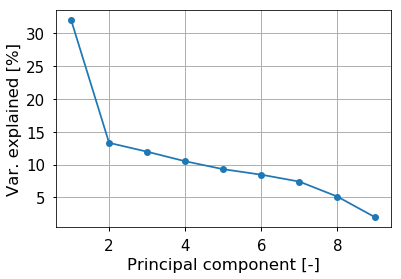

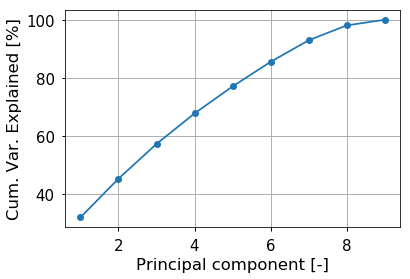

In [11]:
# Define matrix X containing 9 attributes correctly scaled
df_X = data_tr[attribute_names]
X = np.asarray(df_X)

# Perform singular value decomposition
U, S, V = svd(X, full_matrices=False)

# Variance explained
var_explained = S*S / np.sum(S*S)

# Plots of variable explained
plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), var_explained * 100., '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Var. explained [%]')
plt.grid()

plt.figure()
plt.plot(np.arange(1, len(var_explained) + 1), np.cumsum(var_explained * 100.), '-o')
plt.xlabel('Principal component [-]')
plt.ylabel('Cum. Var. Explained [%]')
plt.grid()

### Principal component directions

From the plots below, it can be seen that the predominant direction corresponds to:
 - a) The typeA feature for the first principal component
 - b) The famhist feature for the second principal component

It can be concluded that the typeA feature is the feature that explains most of the variance in the dataset. 

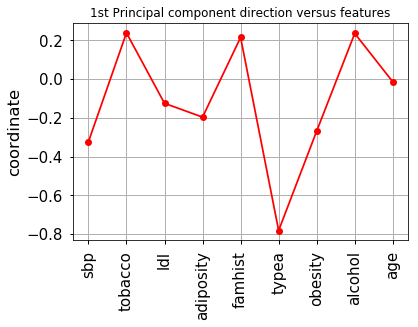

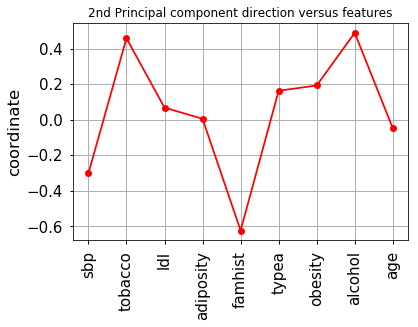

In [12]:
# The eigenvalue vectors or principal components are simply the columns of V, so we transpose V and get the rows.
Vt = V.T

plt.figure()
plt.title('1st Principal component direction versus features', size=12)
plt.plot(np.arange(1,len(Vt[0]) + 1), Vt[0], 'ro-')
plt.xticks(np.arange(1,len(Vt[0]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

plt.figure()
plt.title('2nd Principal component direction versus features', size=12)
plt.plot(np.arange(1,len(Vt[1]) + 1), Vt[1], 'ro-')
plt.xticks(np.arange(1,len(Vt[1]) + 1), list(df_X.columns), rotation='vertical')
plt.ylabel('coordinate')
plt.grid()

### Dataset projected into the first 2 principal components

The projected data can be computed by simply matrix multiplying the transpose of X with the first two eigenvectors of V respectively. We create two sets of X to account for the 2 existing classes.

It can be seen from the plot that:
 - a) as expected, PC1 shows most of the variability of the data (larger scatter in the x direction)
 - b) Both classes overlap quite a lot (it is difficult to find a 'class splitting' rule)

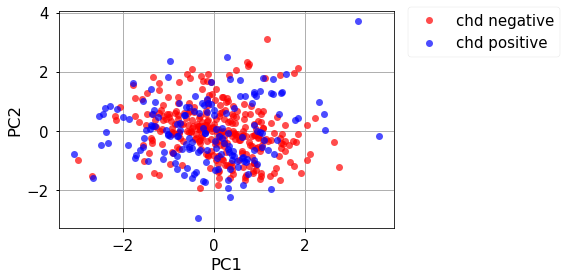

In [13]:
# For plotting purposes, we first create 2 np.ndarrays (X_neg and X_pos) each of them containing a 'chd' class
X_neg = np.asarray(data_tr[attribute_names][data_tr['chd'] == 0])
X_pos = np.asarray(data_tr[attribute_names][data_tr['chd'] == 1])

# 1st component projection
PC1_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[0]).T).flatten()
PC1_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[0]).T).flatten()

# 2nd component projection
PC2_neg = np.asarray(np.matrix(X_neg) @ np.matrix(Vt[1]).T).flatten()
PC2_pos = np.asarray(np.matrix(X_pos) @ np.matrix(Vt[1]).T).flatten()

plt.figure()
plt.plot(PC1_neg, PC2_neg, 'ro', label='chd negative', alpha=0.7)
plt.plot(PC1_pos, PC2_pos, 'bo', label='chd positive', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.02, 1.05))
plt.grid()

# Data description


### 1) Summary statistics of attributes

Mean, Std, Median, Max, Min and 25,75 quantiles have been already calculated in the first section using the describe() method. Computing these quantities was useful since we observed differences in scale between certain attributes and also negleted for potential outliers by looking at the max and min values.


### 2) Covariance analysis
We still have not looked into the potential (linear) correlation between the different attributes. We do this by computing the covariance matrix of the scaled matrix X (which is actually equal to the correlation matrix)

From the plot below, it can be seen than:
 - a) the diagonal elements are the actual variances of each attribute which are equal to 1 since we have scaled X by deviding it by the standard deviation.
 - b) the coviariance matrix is symetric so we should inspect the upper of lower part of the matrix
 - c) correlation between attributes is generally low except for:
       - adiposity versus obesity (0.72) --> moderate linear correlation
       - age versus adiposity (0.63) --> some correlation
       - The remaining pairs have correlation below 0.5





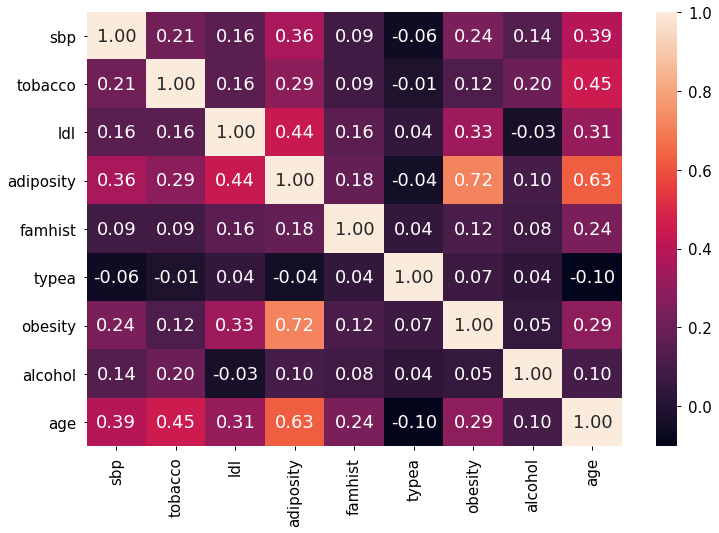

In [14]:
# We Transpose X since the np.cov() function takes each column of X as a single observation
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(np.cov(X.T), xticklabels=df_X.columns, yticklabels=df_X.columns, annot=True, fmt='.2f')

## 3) Data visualization

#### a) Boxplot for each attribute (scaled)
We can confirm by inspecting this plot that there are no apparent outliers in the data. On the other hand, one can also state that the attributes 'alcohol' and 'tabacco' are highly positively skewed. 

#### b) Histogram of each attribute + attribute pair scatter plots (scaled)
This plot tells us alot. The diagonal shows the staked histogram distributions of each attribute considering the 2 existing classes (chd=1 and chd=0). The non-diagonal plots are scatter plots of pairwise attributes. A simple inspection reveals several aspects about this dataset:
 - age histogram follows a close to uniform distribution (ages are almost represented equally)
 - tabacco and alcohol follow a 'negative exponential distribution'
 - all other histrograms are closer to a gausian distribution (some are skewed however, especially sdp and ldl)
 - the scatter plots show a low correlation between variables in general except for the already mentioned pairs ({obesity, adiposity}, {age, adiposity})
 - the scatter plots reveal that overall both classes are difficult to discern (no clear separation)



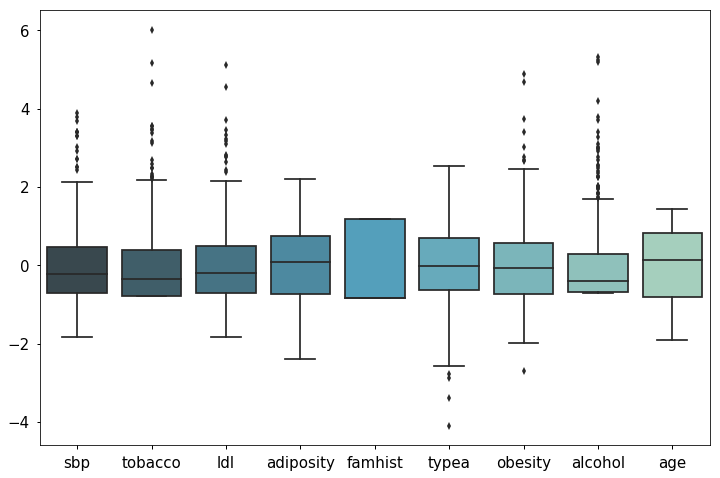

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, data=data_tr[attribute_names],palette='GnBu_d')

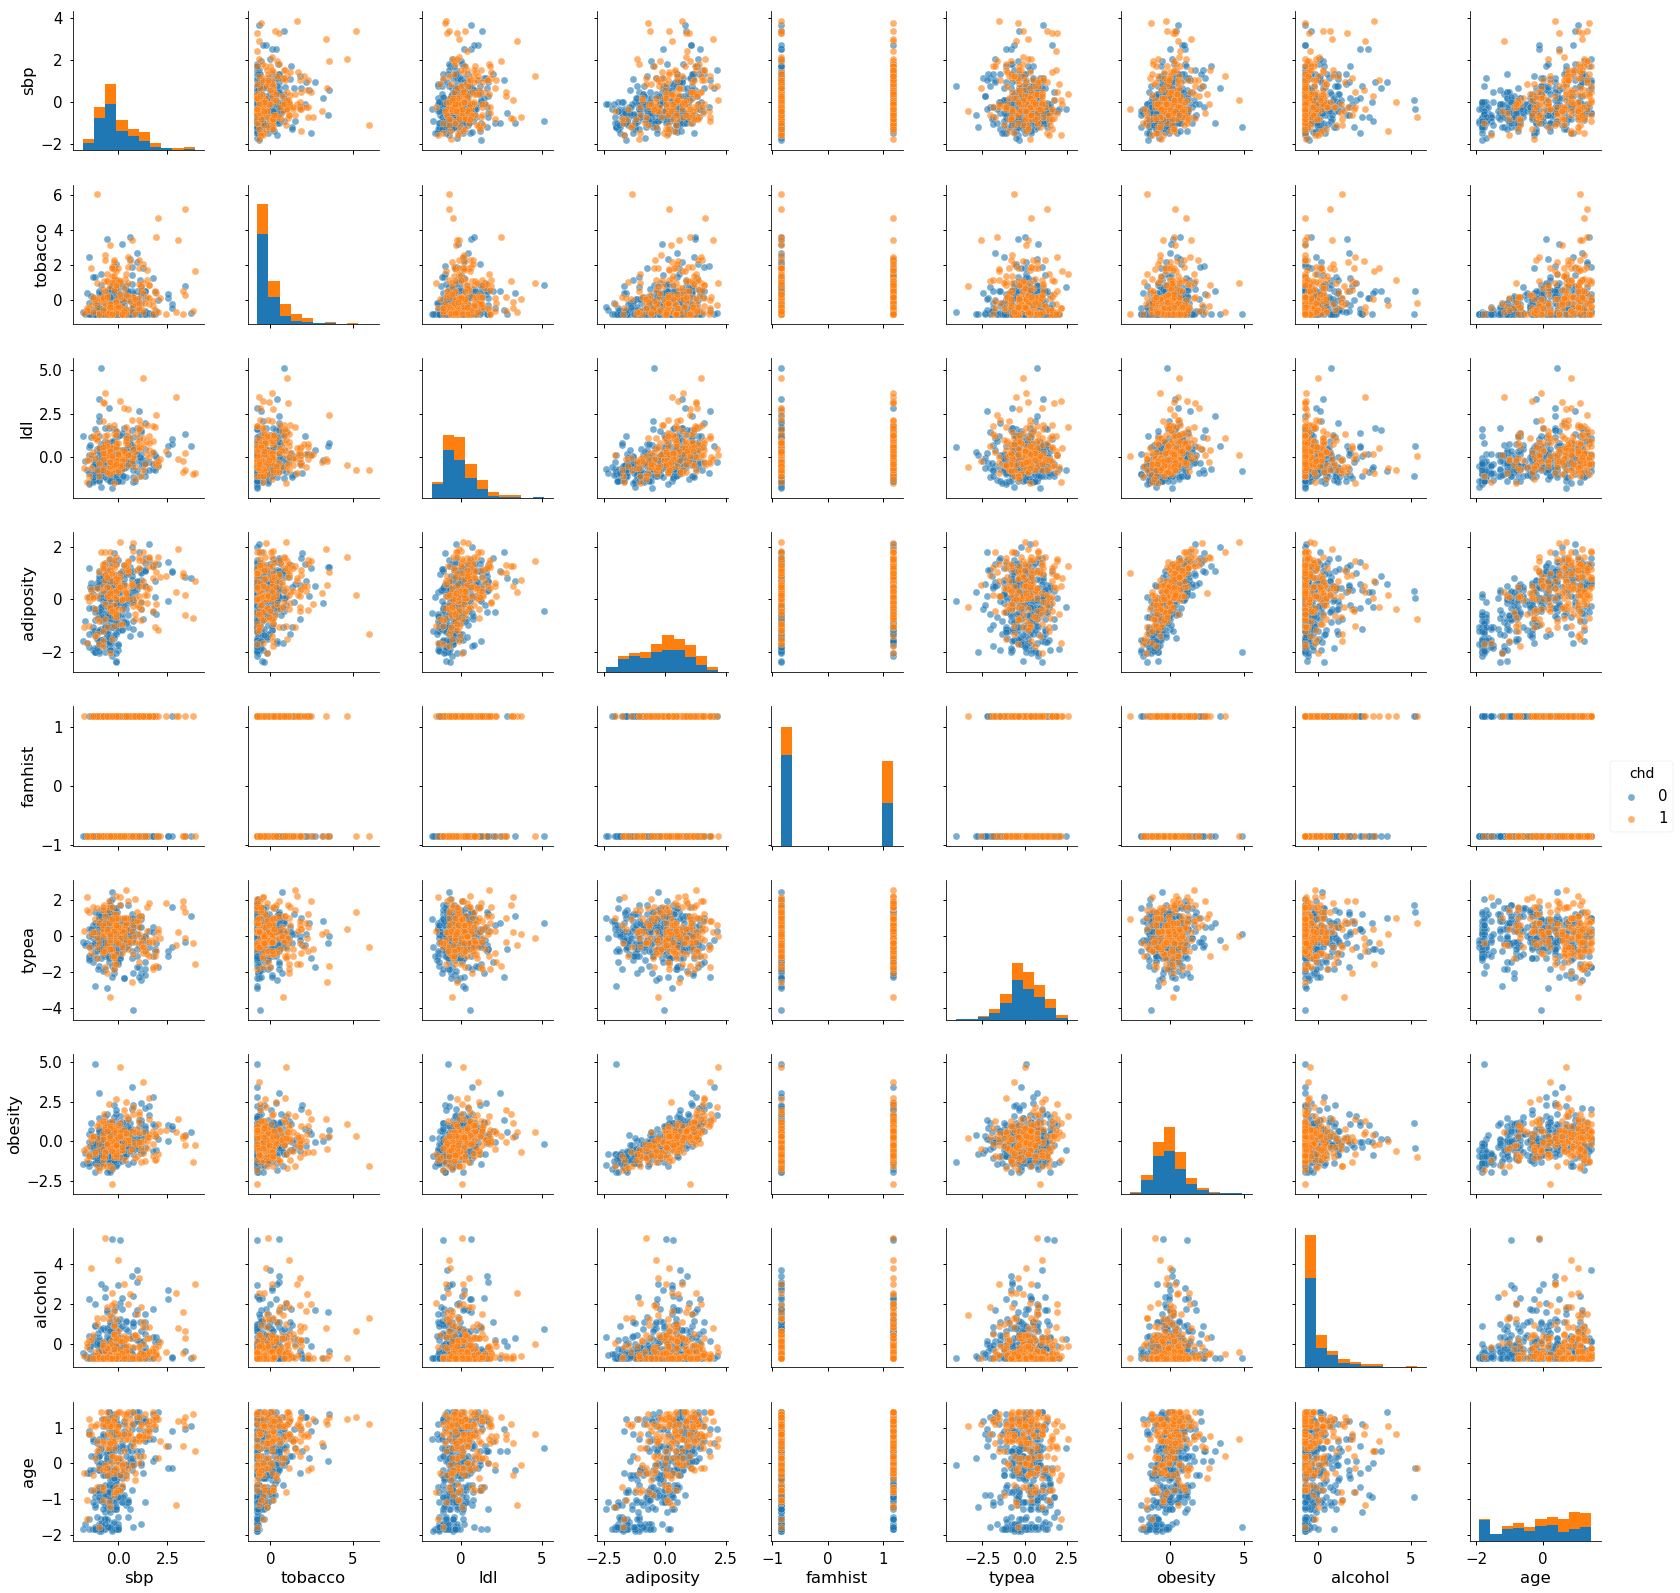

In [16]:
sns.pairplot(data=data_tr, hue='chd',x_vars=attribute_names, y_vars=attribute_names, plot_kws={'alpha': 0.6})

# Supervised learning (classification)

The first section focuses on:

- Illustrating the use of classifiers with the sklearn package (example using Hunt's Decision Tree algorithm)

- Showing how parameter tunning is performed using a 1 layer cross-validation setup.

The second section focuses on:

- Assessing the performance of 4 different classifiers via Generalization roc_auc score in a 2 layer cross-validation setup. 
  
- How two classifiers can be compared (which one is better?)
  

### Problem of interest
Our target variable is the Coronary Heart Disease (chd). We will make binary class predictions using all the 9 available attributes. So in essence:

 - X = {sbp, tabacco, ldl, adiposity, famhist, typea, obesity, alcohol, age}
 - y = chd
 
### Score metric
We use the AUC score (roc_auc in python), to assess performance since our problem suffers from a slight class imbalance.

## Defining feature and target variables for classification
The features and target variable are the original (not transformed)

In [17]:
attribute_class = [col for col in data.columns if col not in ['row.names', 'chd']]

y_c = data['chd']
X_c = data[attribute_class]


## Decision trees and 1 layer cross-validation

We apply Hunt's decision tree algorithm and find the optimal tree depth (hyperparameter tunning) using a simple 1 layer cross-validation setup with 10 folds. 

We leave one observation aside for testing and interpreting the final model (fitted on [all the data - 1] using the tree depth that gave the best cross-validation result).

The *StratifiedKFold* class assures that the partition of the data into training/testing folds keeps the same proportion of the target class than the one observed in the entire dataset.

**Results:**
 - Since we use the 'shuffle' option in *StratifiedKFold* when partitioning the data, the end result changes at every code run
 
 
 - After running the code several times, it can be observed that a tree depth of 3 is most often the optimal tree depth yielding an auc score in the range of 0.7
 
 
 - If a max tree depth of 3 is used, the testing observation is a true negative. One can interpret this result by following the tree provided in the scketch shown below {True --> False --> True}. One ends up in a leave where 73% of the observations in the training set were classified as 'chd absent'
 
**NOTES**: 
 - Decision tree's do not require feature scaling so one can use the original dataset directly
 - the sklearn *GridSearchCV* class is used here for hyperparameter search instead of writing a long for loop. This class is very flexible and useful since it takes any valid cross-validator class directly as argument.

In [18]:
# We leave the first observation out for testing & interpreting the final model (fitted on
# the entire dataset minus the first observation and using the optimal maximum tree depth found 
# using a 10-fold cross-validation)
y_final = y_c[0]
X_final = X_c[0:1]

y_dtc = y_c[1:]
X_dtc = X_c[1:]

#### On the use of GridSearchCV:
The grid search instance (grid_dt) can also be used for prediction when the GridSearchCV class argument refit is set to True (default setting). In this case, the fit method not only fits to all folds specified in the class and makes predictions for all parameter settings, but it also fits all the provided data (X_dtc, y_dtc) to the best found estimator. When applying the predict method it uses the latter fit to make the prediction.

In [19]:
param_grid ={'max_depth' : np.arange(2, 21, 1)}
CV = StratifiedKFold(n_splits=10, shuffle=True)
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring='roc_auc', cv=CV)
grid_dt.fit(X_dtc, y_dtc)

print('The optimal tree depth is {}.'.format(grid_dt.best_params_['max_depth']))
print('Using the optional tree depth yields an AUC score of {}'.format(np.round(grid_dt.best_score_, 3)))

The optimal tree depth is 3.
Using the optional tree depth yields an AUC score of 0.682


In [20]:
prediction = grid_dt.predict(X_final.values)
print('observation:')
print(X_final)
print('\nprediction: {}'.format(int(prediction)))
print('\nobservation: {}'.format(y_final))

observation:
   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age
0  160     12.0  5.73      23.11        1     49     25.3     97.2   52

prediction: 1

observation: 1


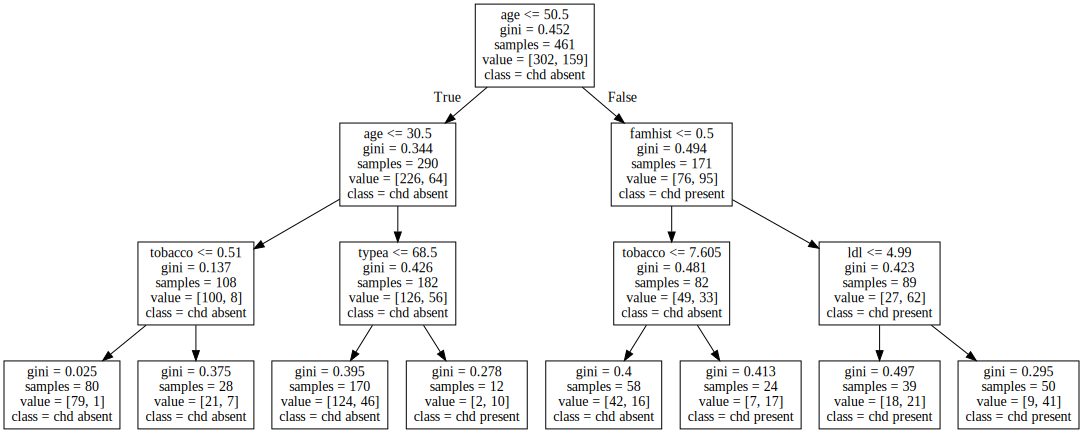

In [21]:
# Tree visualization
out = tree.export_graphviz(grid_dt.best_estimator_, out_file='tree_gini.dot', 
                           feature_names=attribute_names,
                           class_names=['chd absent','chd present'])
with open("tree_gini.dot") as f:
   dot_graph = f.read()
graphviz.Source(dot_graph)

## Generalization roc_auc error for several classifiers

In this section we estimate the generalization roc_auc score for the 4 following classifiers:
    - Decision tree
    - Naive Bayes
    - K-nearest neighboor (knn)
    - Mayority class (reference model, which takes the majority class in the training set as unique prediction)
    
We then evaluate if the 2 best performing classifiers (in terms of generalization roc_auc score) are significantly different (in other words, if one is better than the other).


We estimate the generalization error in a 2 layer cross validation setup where the inner layer is used for selecting the best parameter settings for each outer fold.

#### Sequencial feature transformation using the Pipeline class

We use sklearn's Pipeline and FeatureUnion functionalities to concatenate all the feature transformation steps. The *fit* method applied on a Pipeline instance will fit and transform all the transformers sequencially and will just fit the estimator. The *predict* method will first transform all the test data sequencially before predicting using the provided estimator.

In [22]:
# 2 layer cross-validation settings (common to all three models); we don't use the shuffle option here since 
# we need the same train and test indexes for the 3 models when comparing them.
K = 10
inner_cv = StratifiedKFold(n_splits=K)
outer_cv = StratifiedKFold(n_splits=K)

### knn generalization roc_auc estimate
We scale the data before applying the knn classifier. Scaling in knn is very important since it directly impacts how the distance metric is calculated. A parameter search is done for the number of neighbors and for 2 different distance metrics.

In [23]:
pipe_knn = Pipeline(steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())])

param_grid_knn = {'knn__n_neighbors' : np.array([3,5,11,21,51,71,101]),
                  'knn__metric' : ['euclidean', 'manhattan']}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn, scoring='roc_auc', cv=inner_cv)
nested_scores_knn = cross_val_score(grid_knn, X=X_c, y=y_c, cv=outer_cv)
print('knn generalization roc_auc estimate: {0}'.format(np.round(nested_scores_knn.mean(),3)))
print('std of knn generalization roc_auc: {0}'.format(np.round(nested_scores_knn.std(),3)))

knn generalization roc_auc estimate: 0.764
std of knn generalization roc_auc: 0.061


### Decision tree generalization roc_auc estimate
We scale the data before prediction for convenience (although there is no true impart here as already mentioned) so that this classifier is also evaluated on the same data as for the other classifiers. The parameter seach is done on max tree depth and splitting criterion

In [24]:
pipe_dt = Pipeline(steps=[('scale', StandardScaler()), ('dt', tree.DecisionTreeClassifier())])

param_grid_dt = {'dt__max_depth' : np.arange(2, 21, 1),
                 'dt__criterion' : ['gini', 'entropy']}

grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt, scoring='roc_auc', cv=inner_cv)
nested_scores_dt = cross_val_score(grid_dt, X=X_c, y=y_c, cv=outer_cv)
print('decision tree generalization roc_auc estimate: {0}'.format(np.round(nested_scores_dt.mean(),3)))
print('std of decision tree generalization roc_auc: {0}'.format(np.round(nested_scores_dt.std(),3)))

decision tree generalization roc_auc estimate: 0.706
std of decision tree generalization roc_auc: 0.111


### Majority class classifier generalization roc_auc estimate
This is the reference classifier that we use to evaluate the 'added value' of the 'more sophisticated' classifiers.
It simply takes the majority class in the training set as unique prediction. It comes to no surprise that we get generalized roc_auc score of 0.5 since this score is not sensible to class imbalance. Essencially this corresponds to the accuracy in a non-imbalance dataset.

In [25]:
auc_mc = []
for train_index, test_index in outer_cv.split(X_c, y_c):
    
    y_train = y_c[train_index]
    y_test = y_c[test_index]
    
    y_est = majority_class(y_train) * np.ones(len(y_test))
    auc_mc.append(roc_auc_score(y_test, y_est))
auc_mc = np.array(auc_mc)
print(auc_mc)
print('Majority class classifier generalization roc_auc score is: {0}'.format(np.round(auc_mc.mean(), 3)))

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Majority class classifier generalization roc_auc score is: 0.5


### Naive-Bayes generalization error estimate

In order to properly apply the Naive-Bayes estimator on the data we first need to inspect our features and check:
 - if they are discrete/continuous
 - the distribution of each of the features independently
 
The algorithm requires discrete features for estimating the conditional probabilities p(xi|y=c), so in case the data is not discrete there are two options:
 - binning the data 
 - approximate each feature by a univariate gaussian density distribution
 
In the first case, the sklearn estimator MultinomialNB() would be used and in the second we would use GaussianNB().


When inspecting our features, it turns out that the features types is mixed. All except for **famhist** are continuous attributes. Moreover, when inspecting the pairplot of all variables (see above), it can be seen that the distribution of most of the features is not Gaussian. It is therefore more convenient to bin the data instead of approximating it with a Gaussian density probability distribution.

**NOTE**: For the sake of convenience, we also apply a scaling transformation here (same reason as for the decision tree), but it is worth mentioning that scaling is not required for the Naive-Bayes algorithm 

#### Specific feature transformation

We make use of sklearn's transformer class **FunctionTransformer** and we define our own transformer for subsetting the features. We use sklearn's Pipeline and FeatureUnion functionalities to concatenate all the feature transformation steps smoothly. The resulting pipe is named **preprocess**.

#### GridSearch through preprocessing and estimator parameters

We define a new Pipeline (**pipe_nb**) containing the preprocessing pipe and the MultinomialNB estimator
and search for the best sets of hyperparameters when varying:
 - the number of bins to be used when binning the features (except for famhist which the binning is set to 2)
 - the additive Laplace smoothing parameter

We do this in a 2 layer cross-validation setup like we did for the knn and decision tree models. It is interesting to point out that the GridSearchCV class also allows to 'grid search' on transformer parameters which becomes extremely useful (all can be done in one go).

In [26]:
select_cols = [col for col in df_X.columns if col != 'famhist']

bin_cont = [('select', FilterExtractor(items=select_cols)),
            ('scale', StandardScaler()),
            ('transform', FunctionTransformer(func=bin_digitize))]

bin_disc = [('select', FilterExtractor(items=['famhist'])),
            ('scale', StandardScaler()),
            ('transform', FunctionTransformer(func=bin_digitize, kw_args={'bins':2}))]
            
pipe1 = Pipeline(bin_cont)
pipe2 = Pipeline(bin_disc)
preprocess = FeatureUnion([('cont_attr', pipe1), ('disc_attr', pipe2)])

pipe_nb = Pipeline([('preprocess', preprocess),('nb', MultinomialNB())])

param_grid_nb = {'nb__alpha' : np.array([0.5, 0.75, 1]),
                 'preprocess__cont_attr__transform__kw_args' : mapping_list(np.arange(20,60,10))}

grid_nb = GridSearchCV(pipe_nb, param_grid_nb, scoring='roc_auc', cv=inner_cv)
nested_scores_nb = cross_val_score(grid_nb, X=X_c, y=y_c, scoring='roc_auc', cv=outer_cv)

print('Naive Bayes generalization roc_auc estimate: {0}'.format(np.round(nested_scores_nb.mean(),3)))
print('std of Naive Bayes generalization roc_auc: {0}'.format(np.round(nested_scores_nb.std(),3)))

Naive Bayes generalization roc_auc estimate: 0.676
std of Naive Bayes generalization roc_auc: 0.091


#### Storing classifer roc_auc results in a dataframe
It can be easily seen that all classifiers perform better than the Majority class classifier which indicates that modelling adds value.

In [27]:
scores = [nested_scores_knn, nested_scores_dt, nested_scores_nb, auc_mc]
fold_columns = ['fold{0}'.format(i) for i in np.arange(1,11)]
classifier_df = pd.DataFrame(scores, 
                             columns=fold_columns, 
                             index=['knn', 'Decision tree', 'Naive-Bayes', 'Majority class'])
classifier_df['mean'] = classifier_df.mean(axis=1)
classifier_df['std'] = classifier_df.std(axis=1)
classifier_df

,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean,std
knn,0.785282,0.728831,0.769792,0.670833,0.678125,0.775000,0.720833,0.850000,0.831250,0.834375,0.764432,0.060524
Decision tree,0.796371,0.483871,0.802083,0.625000,0.531250,0.733333,0.745833,0.757292,0.780208,0.800000,0.705524,0.110970
Naive-Bayes,0.705645,0.635081,0.833333,0.670833,0.527083,0.631250,0.572917,0.743750,0.637500,0.797917,0.675531,0.091144
Majority class,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


Text(0,0.5,'roc_auc')

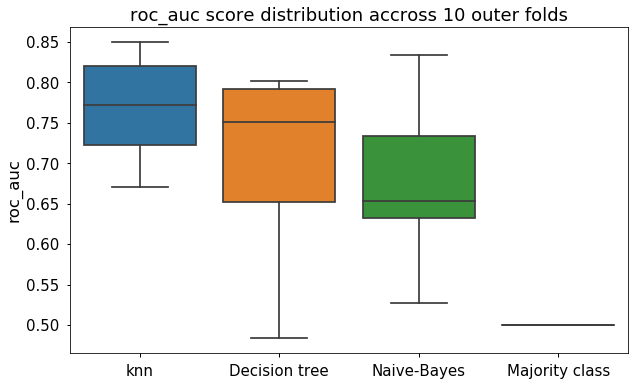

In [28]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=classifier_df[classifier_df.columns[:-2]].T)
ax.set_title('roc_auc score distribution accross {} outer folds'.format(K))
ax.set_ylabel('roc_auc')

## Comparing the knn and Decision tree classifiers

We compute the 95% credibility interval of the difference of the generalization roc_auc scores of the 2 classifiers. The two confidence bands are larger than zero so it can be concluded that the knn classifier is better than the Decision tree classifier with a 95% credibility.

In [29]:
clas_model1 = classifier_df.loc['knn', fold_columns]
clas_model2 = classifier_df.loc['Decision tree', fold_columns]

cre_intervals = compare_models(clas_model1, clas_model2)
cre_intervals

The two models are not significantly different


[-0.005117640887306936, 0.12293350110236073]

# Supervised learning (regression)


The first section illustrates the use of linear regression (least-square regression) with feature transformation and  feature selection. The *Forward sequencial feature selection algorithm (SFS)* provided in the mlxtend package is used for feature selection. Polynomial and Interaction transformations between features are considered only here. The generalized MSE error is computed for the following two cases:
  - Adding Feature transformations --> Feature Selection --> Linear regression
  - Linear regression directly on all features
  
A final model (for the linear regression + transforms + feature selection case) is obtained by fitting to the entire dataset. Finally, this model is interpreted in terms of the linear model weights found.

The second section focuses on assessing the performance of 6 different regression models (which include the linear regression models found in the first section) via Generalization MSE in a 2 layer cross-validation setup. The regression models are:
  - Linear Regression least-squares with feature transformation(s) + feature selection
  - Linear Regression least-squares plain
  - Ridge regression (L2 regularization)
  - Lasso regression (L1 regularization)
  - ANN (feedforward Multi-Layer Perception)
  - Naive Average Model (reference model, which takes the mean of the training data as estimate)
  
These models are then compared with each other using credibility interval reasoning.
  

### Problem of interest

We will attempt to predict obesity. We will use the attributes shown below (we exclude famhist since this feature can only take two values, and will in consequence not bring much information into a linear model). So in essence:

 - X = {sbp, tobacco, ldl, adiposity, typea, alcohol, age}
 - y = obesity

## Defining feature and target variables for regression
The features and target variable are the original (not transformed)

In [30]:
y_reg = data['obesity']
X_reg = data[[col for col in data.columns if col not in ['obesity', 'chd', 'row.names','famhist']]]

##  Linear regression with transformed features + SFS feature selection

We define a Pipeline which stacks together the following transformers and final estimator:
   - a) Transformer that adds feature polynomials + interaction terms
   - b) StandardScaler Transformer (scales the resulting feature from a)
   - c) SFS Transformer which filters the best features by an inner cross-validation loop (defined via cv_inner_reg)
   - d) Our final estimator (LinearRegression Sklearn class) which fits the scaled best selected features with the target value.
   

We compute the Generalized MSE in an outer cv fold (cv_outer_reg) passing the mentioned Pipeline to *cross_val_score*. We then monitor the Generalized MSE value by proceding in the following fashion:
   - 1) considering all attributes without including any transformations
   - 2) considering all attributes including polynomial transformations of the most relevant attributes found in 1)
   - 3) Most relevant set of attributes found in 2) including interaction terms.
   
We take the feature transformation combination that yields the lowest Generalized MSE.
     
__Results:__
   - When performing step 1, we observe that the most relevant attributes are (in order): __{adiposity, age, typea}__


   - In step 1 we observe that the apidosity residuals (most relevant feature) have a slight curvature which suggests that adding adiposity polynomial transformations into the algorithm might improve results. The same can be said about the age attribute.
   
   
   - It was found (step 2), that including the square of adiposity and the square of age increased model performance.
    Moreover, the residuals are observed to behave more randomly (no clear trend) which suggest that the data has been transformed successfully.
   
   
   - Including the interaction term between age and adiposity was tested (step 3) but this did not lead to an improvement of the MSE.
   
   
   - The improvement is Generalized MSE is not negligable (from 7.99 to 7.56)
   
   
   - The best model is finally constructed by fitting the Linear Regression model after scaling and feature selection using the outer cv fold on the entire dataset. It contains the 4 following attributes (in order of importance)
   __{p(adiposity)2, p(age)2, typea, age}__
   
   
   - It can be observed that the weights of the linear model correspond in terms of absolute value to the feature importance ranking found by SFS. (the data is scaled so one can interpret the model)

#### Setting inner and outer cv folds for all regression models

In [ ]:
K_outer = 10
K_inner = 10
cv_inner_reg = KFold(n_splits=K_inner)
cv_outer_reg = KFold(n_splits=K_outer)

#### Setting polynomial + interaction terms to features

In [31]:
poly_terms = {'adiposity' : [2, 3], 'age' : [2]}
iter_terms = None

#### MSE Generalization estimate for simple lreg and fs lreg

In [33]:
sfs = SFS(estimator=LinearRegression(), 
          k_features='best',
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=cv_inner_reg)

steps_lreg_fs =   [('extra_terms', ExtraFeaturesTransform(power_dict=poly_terms, int_list=iter_terms)),
                   ('scale', StandardScaler()),
                   ('sfs', sfs),
                   ('lreg', LinearRegression())]

steps_lreg_nofs =   [('scale', StandardScaler()),
                     ('sfs', sfs),
                     ('lreg', LinearRegression())]

pipe_lreg_fs = Pipeline(steps=steps_lreg_fs)
pipe_lreg_nofs = Pipeline(steps=steps_lreg_nofs)

nestcv_lreg_fs = cross_val_score(pipe_lreg_fs, X_reg, y_reg, scoring='neg_mean_squared_error', cv=cv_outer_reg)
nestcv_lreg_nofs = cross_val_score(pipe_lreg_nofs, X_reg, y_reg, scoring='neg_mean_squared_error', cv=cv_outer_reg)

print('linear regression (least-squares) Generalization MSE with feature selection + feature transforms: {}'.format(np.round(-nestcv_lreg_fs.mean(), 3)))
print('linear regression (least-squares) Generalization MSE with no feature selection: {}'.format(np.round(-nestcv_lreg_nofs.mean(), 3)))

linear regression (least-squares) Generalization MSE with feature selection + feature transforms: 7.56
linear regression (least-squares) Generalization MSE with no feature selection: 7.99


#### Extracting residuals + relevant info from feature selection
 - We store the residuals generated in the outer loop (we are forced to decompose *cross_val_score*) 
 - We extract the history of the SFS algorithm for every outer cv fold.
 - We store the best selected features in each outer cv fold in a list of tuples
 - We compute the Generalized MSE again (just for checking)

In [37]:
cv_fold_selected_features, residuals, mse_list, inner_loop_res = [], [], [], []

transform_steps  =[('extra_terms', ExtraFeaturesTransform(power_dict=poly_terms)),
                   ('scale', StandardScaler()),
                   ('sfs', sfs)]
k=1
for index_train, index_test in cv_outer_reg.split(X_reg):
    
    residuals_df = pd.DataFrame()
    cv_fold_str = 'CVfold{}'.format(k)
    
    X_train, y_train = X_reg.iloc[index_train], y_reg.iloc[index_train]
    X_test, y_test = X_reg.iloc[index_test], y_reg.iloc[index_test]
    
    # Pipeline only containing transforms (we do this so that we 
    # can save the transformed of X_test --> X_test_trs for residual plotting)
    pipe_trans = Pipeline(steps=transform_steps)
    pipe_trans.fit(X_train, y_train)
    X_test_trs = pipe_trans.transform(X_test)
    
    # Pipeline containing all steps (with final estimator at the end)
    pipe_all = Pipeline(steps=transform_steps + [('lreg', LinearRegression())])
    pipe_all.fit(X_train, y_train)
    y_est = pipe_all.predict(X_test)
    
    # Computing again mse
    mse_list.append(mse(y_test, y_est))
    
     # Storing selected features in each outer cvfold
    feature_names = pd.Series(list(pipe_all.named_steps.extra_terms.feature_cols_))
    selected_features = list(feature_names[list(pipe_all.named_steps.sfs.k_feature_idx_)])
    cv_fold_selected_features.append(tuple(selected_features))
    
    # storing inner loop results for convenience
    inner_df = pd.DataFrame.from_dict(pipe_all.named_steps.sfs.get_metric_dict()).T
    inner_df['features'] = inner_df['feature_idx'].apply(lambda x: list(feature_names[list(x)]))
    inner_loop_res.append(inner_df)
    
    # Storing residuals
    residuals_df = pd.DataFrame(X_test_trs, columns=selected_features)
    residuals_df['residuals'] = list(y_est - y_test)
    residuals.append(residuals_df.reset_index(drop=True))
    k+=1
    
mse_array = np.array(mse_list)
print(mse_array)
print('linear regression (least-squares) Generalization MSE with feature selection + feature transforms: {}'.format(np.round(mse_array.mean(), 3)))

[21.1172018   6.78169152  6.0741287   5.13479462  4.45943067  6.51319656
  5.26752923  5.98148996  4.57345235  9.69477337]
linear regression (least-squares) Generalization MSE with feature selection + feature transforms: 7.56


#### Best selected features in each outer cv fold

In [38]:
cv_fold_selected_features

[('sbp', 'typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('tobacco', 'ldl', 'typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('tobacco', 'typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2'),
 ('typea', 'age', 'p(adiposity)2', 'p(age)2')]

### Inspect residuals and SFS history for a give outer fold

In [68]:
# Set a cv fold number
cvfold = 6

In [43]:
inner_loop_res[cvfold - 1].head()

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err,features
1,-8.23261,3.65982,"[-6.666902085066095, -22.518675973215892, -6.5...","(7,)",4.92764,1.64255,[p(adiposity)2]
2,-7.65189,3.63238,"[-7.283970392594499, -21.238988069108814, -4.9...","(7, 9)",4.89069,1.63023,"[p(adiposity)2, p(age)2]"
3,-7.5859,3.71037,"[-7.141253057208789, -21.54013231750735, -4.76...","(4, 7, 9)",4.9957,1.66523,"[typea, p(adiposity)2, p(age)2]"
4,-7.5742,3.80947,"[-7.230905156499365, -22.01320601710904, -4.71...","(4, 6, 7, 9)",5.12913,1.70971,"[typea, age, p(adiposity)2, p(age)2]"
5,-7.59295,3.80403,"[-7.239181085922285, -22.011779974490647, -4.7...","(2, 4, 6, 7, 9)",5.1218,1.70727,"[ldl, typea, age, p(adiposity)2, p(age)2]"


Text(0.5,1,'SFS results in CVfold6 (w. StdErr)')

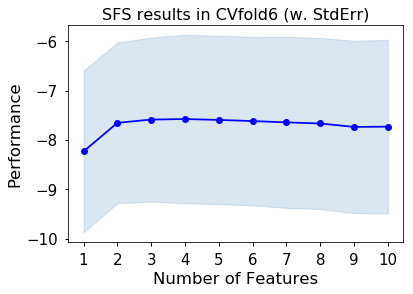

In [44]:
fig1 = plot_sfs(inner_loop_res[cvfold - 1].T, kind='std_err')
plt.title('SFS results in CVfold{} (w. StdErr)'.format(cvfold), size=16)

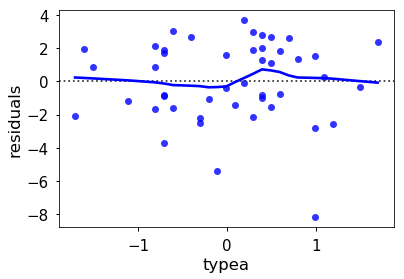

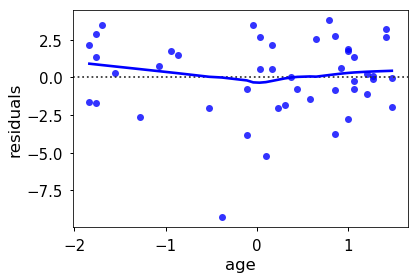

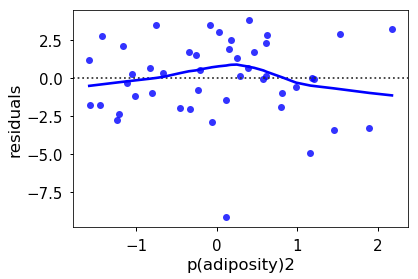

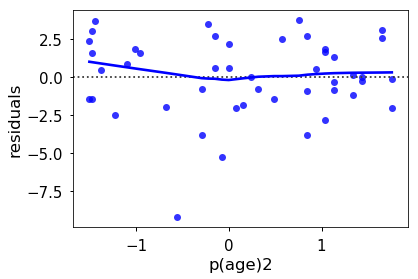

In [45]:
res_df = residuals[cvfold - 1]
for i in [col for col in res_df.columns if col != 'residuals']:
    plt.figure()
    sns.residplot(res_df[i], res_df['residuals'], lowess=True, color="b")

### Fitting the final model

In [48]:
sfs_final = SFS(estimator=LinearRegression(), 
                k_features='best',
                forward=True, 
                floating=False, 
                scoring='neg_mean_squared_error',
                cv=cv_outer_reg)

steps_final = [('extra_terms', ExtraFeaturesTransform(power_dict=poly_terms)),
                ('scale', StandardScaler()),
                ('sfs', sfs),
                ('lreg', LinearRegression())]

pipe_final = Pipeline(steps=steps_final)
pipe_final.fit(X_reg, y_reg)
pipe_final.named_steps.sfs.k_feature_idx_

all_cols = pd.Series(list(pipe_final.named_steps.extra_terms.feature_cols_))
features_idx = list(pipe_final.named_steps.sfs.k_feature_idx_)
final_features = all_cols.iloc[features_idx]
print('Final model selected features are: {}'.format(list(final_features)))

Final model selected features are: ['typea', 'age', 'p(adiposity)2', 'p(age)2']


#### Final model SFS sequence

In [49]:
cv_results = pd.DataFrame.from_dict(pipe_final.named_steps.sfs.get_metric_dict()).T
# adding feature names to dataframe
cv_results['features'] = cv_results['feature_idx'].apply(lambda x: list(all_cols[list(x)]))
cv_results.head()

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err,features
1,-8.26302,3.02392,"[-20.02385032487036, -7.337243132672874, -7.30...","(7,)",4.07145,1.35715,[p(adiposity)2]
2,-7.60417,3.28715,"[-20.06669524530745, -6.487458204675049, -5.86...","(7, 9)",4.42587,1.47529,"[p(adiposity)2, p(age)2]"
3,-7.51142,3.26763,"[-19.900094833693338, -6.962574960400559, -5.7...","(4, 7, 9)",4.39958,1.46653,"[typea, p(adiposity)2, p(age)2]"
4,-7.47985,3.4538,"[-20.75038452542631, -6.781691515462909, -5.80...","(4, 6, 7, 9)",4.65025,1.55008,"[typea, age, p(adiposity)2, p(age)2]"
5,-7.49281,3.45172,"[-20.74800893212017, -6.779369303481473, -5.80...","(4, 5, 6, 7, 9)",4.64745,1.54915,"[typea, alcohol, age, p(adiposity)2, p(age)2]"


#### Obtaining final model weights

In [50]:
w_coefs = pd.DataFrame()
w_coefs['w'] = [pipe_final.named_steps.lreg.intercept_] + list(pipe_final.named_steps.lreg.coef_)
w_coefs['variable'] = ['intercept'] + list(final_features)
w_coefs

,w,variable
0,26.044113,intercept
1,0.308646,typea
2,1.696723,age
3,3.574345,p(adiposity)2
4,-2.617389,p(age)2


#  Ridge, Lasso & ANN (1 hidden layer) models in regression

In addition to the Linear Model (least-squares), we compute the generalization mse (mean square error) of these three other models and compare these results with the mse of a simple 'average' regressor (named Naive regressor from now) that takes the mean of the training target values as estimate. This last model is used as our performance reference model. 

We then compare different model pairs by assessing whether a model is better than the other with a certain confidence. This is done using confidence interval reasoning (cdf of the t-Student distribution).

**NOTE**: We use the exact same inner and outer cross validation splits that were defined at the beginning of this section. An exception will be made with the inner cv fold of the ANN model which is taken as holdout since it was too computationally demanding otherwise

### Naive Regressor generalization MSE

We simply take the average of the y training data as our y estimate in each outer cross-validation fold (no inner cross-validation since there is no parameter tunning) and we compare these estimates with the testing y data.

In [53]:
error_naive = []
for train_index, test_index in cv_outer_reg.split(X_reg):
    
    y_train = y_reg.iloc[train_index]
    y_test = y_reg.iloc[test_index]
    y_est = y_train.mean() * np.ones(len(y_test))
    error_naive.append(mse(y_test, y_est))
error_naive = np.array(error_naive)
print(error_naive)
print('Naive regressor generalization MSE is: {0}'.format(np.round(error_naive.mean(), 3)))

[23.73090457 21.00008559 18.1232166  17.37568495 16.47583498 18.15646105
 16.35343339 11.04886835 17.86207397 18.35165935]
Naive regressor generalization MSE is: 17.848


### Ridge regression generalization MSE

We use a Pipeline to stack a scaling transformer and the Ridge regression estimator. We estimate the optimal regularization parameter (alpha) using the inner cv folds for each outer fold. The generalization MSE is estimated taking the mean of the best performing models evaluated in the outer folds. Once again we use sklearn's GridSearch and cross_val_score for this calculation.

In [54]:
pipe_ridge = Pipeline(steps=[('scale', StandardScaler()),('ridge', Ridge())])

alphas = {'ridge__alpha' : np.array([1e-6, 1e-4, 1e-2, 1e-1 ,1, 10, 50, 100])}
grid_rd = GridSearchCV(pipe_ridge, param_grid=alphas, scoring='neg_mean_squared_error', cv=cv_inner_reg)
nested_scores_rd = cross_val_score(grid_rd, X=X_reg, y=y_reg, scoring='neg_mean_squared_error', 
                                   cv=cv_outer_reg)
print(nested_scores_rd*-1)
print('Ridge regression generalization MSE is: {0}'.format(np.round(-nested_scores_rd.mean(),3)))

[21.49661303  7.48281018  6.4398408   5.92478979  5.19574187  7.34845236
  5.77644491  5.23144709  5.19614875  9.80086107]
Ridge regression generalization MSE is: 7.989


### Lasso regression generalization MSE

Same technique for cross-validation is used here. The regularization parameter alpha is the only parameter tunned in the inner cv folds.

In [55]:
pipe_lasso = Pipeline(steps=[('scale', StandardScaler()),('lasso', Lasso())])

alphas_l = {'lasso__alpha' : np.array([1e-8, 1e-6, 1e-4, 1e-2, 1e-1 ,1, 10, 50])}
grid_ls = GridSearchCV(pipe_lasso, param_grid=alphas_l, scoring='neg_mean_squared_error', cv=cv_inner_reg)
nested_scores_ls = cross_val_score(grid_ls, X=X_reg, y=y_reg, scoring='neg_mean_squared_error', 
                                   cv=cv_outer_reg)
print(nested_scores_ls*-1)
print('Lasso regression generalization MSE is: {0}'.format(np.round(-nested_scores_ls.mean(),3)))

[21.48378464  7.47201364  6.43018649  5.92562665  5.19738978  7.38680817
  5.78871677  5.23590951  5.19633645  9.78824563]
Lasso regression generalization MSE is: 7.991


### Multi-Layer Perceptron (ANN) setup

Sklearn's MLPRegression class in used here.

Fitting a feedforward multi-layer perceptron suffers from the problem of local minimas. We overcome this by using a fitting strategy that fits the model to the same data using several random initializations of model weights. This is controled by the parameter n_train. The model that yields the smallest error loss (E(w)) is kept for later prediction. 

A drawback which result from this is that one can no longer use sklearn's *GridSearchCV* in combination with *cross_val_score* to easily compute the generalization error since these methods use the default fit method. Nonetheless, one could potentially overcome this by defining a new estimator which would inherit from the MLPRegression class and code up a new *fit* method that would overwrite the default one. 

This path was not pursued here; in contrast, and for the sake of model control, the inner an outer loops were coded manually using a new custom fit method (*fit_ann*) and relevant modelling info is logged (using the hierarchy from the logging module).

### ANN 2-layer CV strategy

We use a holdout validation fold in the inner loop due to computational constraints. This is achieved using the developed *optimal_ann_holdout* function which essencially returns the best model hyperparameter set after an exaustive search using the holdout method. this function takes a parameter grid dictionary as input (mimics the behavior of *GridSearchCV*).

The outer loop uses the same partitioning then the other regression models (for the sake of model performance comparison)

### Comments on the ANN results

After some intensive testing with sklean's MLPRegression model, it has been found that:
 - the **lbfgs** solver is significantly faster than the default **adam** solver for this particular problem. The literature suggests that the **adam** solver is a better choice when dealing with a large dataset and that for smaller datasets the **lbfgs** solver is more effective as experienced here.
 
 
 - the hidden layer default activation function **relu** (max(0,x) was sometimes prone to predict very 'wrong' values which really affected the MSE (the square penalizes bad predictions a lot)). A fixed predicted minimum value was also observed using this activation function
  
  
 - the **tanh/logistic** activation functions performed better (less overshooting issues than when using the **relu** function) and no fixed minimum value observed.

### ANN settings

In [56]:
# ann solver strategy settings:
ann_args = {'max_iter'   : 7000,
            'tol'        : 1e-5,
            'solver'     : 'lbfgs',
            'verbose'    : False,
            'activation' : 'tanh'}

# Number of ann trainings using different weight initializations. 
# NOTE: This is done in order to avoid finding a local minima as solution.
# The solution with the lower loss (or training error) in the n_train ann trainings is kept.
n_train = 5

# MLPREgressor parameter grid for serching best model in inner holdout loop
param_grid = {'hidden_layer_sizes' : [(1,), (2,), (4,), (6,), (10,)]}

# Transformer(s) to apply to the data before calling the ann estimator (as a list of tuples)
transformers = [('scale', StandardScaler())]
    
# Logger debug level
debug_level='CRITICAL'

# show prediction plots
show_plots = False

### ANN 2 layer Cross-validation loop yielding a generalization mse estimate

In [57]:
# Create logger
logger = gen_logger(verb=debug_level)

# Main loop
k = 0
error_final = []
for train_index, test_index in cv_outer_reg.split(X_reg):
    
    X_train, y_train = X_reg.iloc[train_index], y_reg.iloc[train_index]
    X_test, y_test = X_reg.iloc[test_index], y_reg.iloc[test_index]
    
    logger.warning('\n=========== Crossvalidation fold: {0}/{1} ==========='.format(k+1,K_outer))
    
    # Finding best model parameters in inner holdout loop
    best_params = net.optimal_ann_holdout(X_train, 
                                          y_train,
                                          param_grid,
                                          logger,
                                          transformers=transformers,
                                          n_train=n_train,
                                          **ann_args) 
    # Optimal Model
    ann = MLPRegressor(**best_params)
         
    # Create Pipeline using the standard scaler transformer
    pipe_final = Pipeline(steps=transformers + [('ann', ann)])
    
    # Fit model to training data
    logger.warning('\nFitting best model on outer CV fold {}/{}...'.format(k+1, K_outer))
    bestnet = net.fit_ann(X_train, y_train, n_train, pipe_final, logger, joblibfile='ann_outer.pkl')
    
    # Make prediction with best ann model and store mse error
    y_est = bestnet.predict(X_test)
    error_final.append(mse(y_test, y_est))
    k+=1
    
    if show_plots:
        plt.figure()
        max_ = np.array(list(y_est) + list(y_test)).max()
        min_ = np.array(list(y_est) + list(y_test)).min()    
        plt.plot(y_est, y_test,'ro')
        plt.plot((min_, max_),(min_, max_), '--')
        plt.xlabel('model')
        plt.ylabel('true')

error_final = np.array(error_final)
print(error_final)
logger.critical('\n===== FINAL RESULTS =====')
logger.critical('ANN Generalization MSE error estimate is {}'.format(np.round(error_final.mean(), 2)))
logger.critical('std of ANN Generalization MSE error is {}'.format(np.round(error_final.std(), 2)))


===== FINAL RESULTS =====
ANN Generalization MSE error estimate is 7.6
std of ANN Generalization MSE error is 4.58


[20.288057    6.57899695  6.11601223  5.02260399  3.89465059  6.64722792
  5.3354293   5.8056571   5.35302771 10.94645449]


#### Storing Regression MSE results in dataframe

In [59]:
scores = [error_naive, -nestcv_lreg_nofs, -nestcv_lreg_fs, -nested_scores_rd, -nested_scores_ls, error_final]
fold_columns = ['fold{0}'.format(i) for i in np.arange(1,K_outer + 1)]
regression_df = pd.DataFrame(scores, 
                             columns=fold_columns, 
                             index=['Naive', 'Lreg', 'Lreg_sfs', 'Ridge', 'Lasso', 'ANN'])
regression_df['mean'] = regression_df.mean(axis=1)
regression_df['std'] = regression_df.std(axis=1)
regression_df

,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,mean,std
Naive,23.730905,21.000086,18.123217,17.375685,16.475835,18.156461,16.353433,11.048868,17.862074,18.351659,17.847822,3.090903
Lreg,21.569189,7.331034,6.350731,5.997751,5.233540,7.438143,5.863902,5.251456,5.012368,9.848083,7.989620,4.729970
Lreg_sfs,21.117202,6.781692,6.074129,5.134795,4.459431,6.513197,5.267529,5.981490,4.573452,9.694773,7.559769,4.737363
Ridge,21.496613,7.482810,6.439841,5.924790,5.195742,7.348452,5.776445,5.231447,5.196149,9.800861,7.989315,4.702846
Lasso,21.483785,7.472014,6.430186,5.925627,5.197390,7.386808,5.788717,5.235910,5.196336,9.788246,7.990502,4.697623
ANN,20.288057,6.578997,6.116012,5.022604,3.894651,6.647228,5.335429,5.805657,5.353028,10.946454,7.598812,4.583747


#### Boxplot of MSE scores

Text(0,0.5,'MSE')

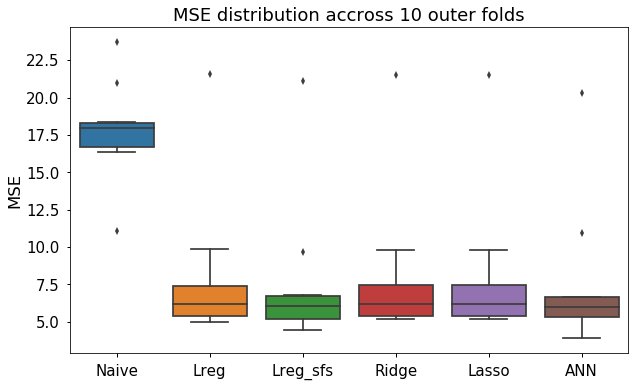

In [60]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data=regression_df[regression_df.columns[:-2]].T)
ax.set_title('MSE distribution accross {} outer folds'.format(K_outer))
ax.set_ylabel('MSE')

### Discussing regression results

From the box plot and dataframe results table one can conclude that:
 - The Naive model performs significantly worse than all the other models which confirms that 'modelling' is valuable in this particular problem
 
 
 - Both Ridge and Lasso regression behave similiarly; in other words, L1 or L2 regularization has barely no impact
   on the generalization error
   
   
 - It can be observed that in general all models behave similarly.
   
   
 - The Ann MLP and the linear least-square model with feature selection seem to perform slighly better than the rest.
 When comparing different model pairs using a credibility interval analysis with 95% confidence, it is observed that the linear regression model with feature selection is significantly different (better) than all the other models except for the ANN. In contrast the ANN model compared to the others gives no significant difference. 


### Comparing the 2 best performing regression models

In [66]:
model1 = regression_df.loc['Lreg_sfs', fold_columns]
model2 = regression_df.loc['Lasso', fold_columns]

conf_intervals = compare_models(model1, model2)
conf_intervals

The two models are significantly different.


[-0.7897196495857168, -0.07174614052405026]